# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)


# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Part 1:

Show a 10x10 grid that visualizes 10 examples of each digit.

Notes:
* You can use `plt.rc()` for setting the colormap, for example to black and white.
* You can use `plt.subplot()` for creating subplots.
* You can use `plt.imshow()` for rendering a matrix.
* You can use `np.array.reshape()` for reshaping a 1D feature vector into a 2D matrix (for rendering).

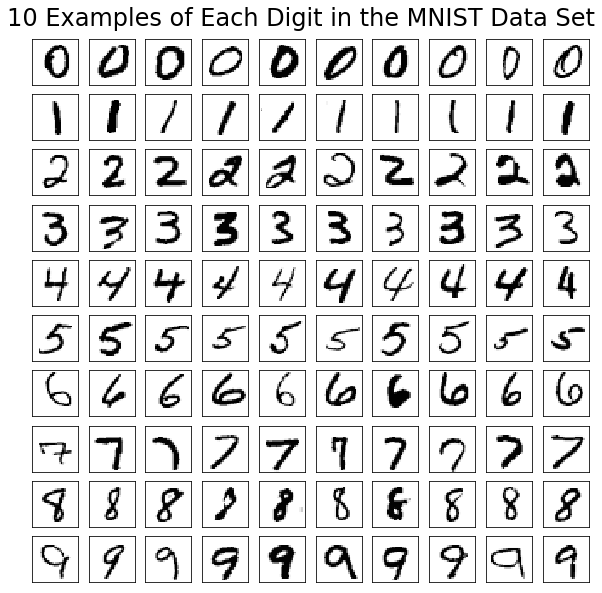

In [229]:
def P1(num_examples=10):
    
    num_labels = 10
    #Initialize a list of 10 lists. The index for each list in the list corresponds to a label in the data. 
    example_indices = [[] for i in range(num_labels)]
    
    #iterate through the train_labels to get the first num_examples for each label.
    #Assumes there are at least num_examples of each label
    index = 0
    for label in mini_train_labels:
        #labels are strings so coerce to int
        label = int(label)
        if len(example_indices[label]) < num_examples:
            example_indices[label].append(index)
        index += 1
        
    #plot the matrix
    fig, axes = plt.subplots(num_labels,num_examples,figsize = (10,10))
    fig.suptitle('%s Examples of Each Digit in the MNIST Data Set'%num_examples,fontsize = 24, y = 0.925)
    
    #iterate through each label and then each example for each label
    for i in range(num_labels):
        for j in range(num_examples):
            #reshape the indicated index in the training data and add it to the figure
            axes[i,j].imshow(train_data[example_indices[i][j]].reshape(28,28), cmap = 'Greys')
            # remove the tick marks and labels for each plot as they are irrelevant for just displaying examples
            axes[i,j].get_xaxis().set_ticks([])
            axes[i,j].get_yaxis().set_ticks([])
    plt.show()
    
P1(10)

### Part 2:

Produce k-Nearest-Neighbors model with k = [1,3,5,7,9].  Evaluate and show the performance of each model. For the 1-Nearest Neighbor model, show precision, recall, and F1 for each label. Which is the most difficult digit?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `classification_report` to get precision, recall, and F1 results.

Classification Report: k = 1
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

k = 1, Test Accuracy = 0.884
k = 3, Test Accuracy = 0.876
k = 5, Test Accuracy = 0.882
k = 7, Test Accuracy = 0.877
k = 9, Test Accuracy = 0.875


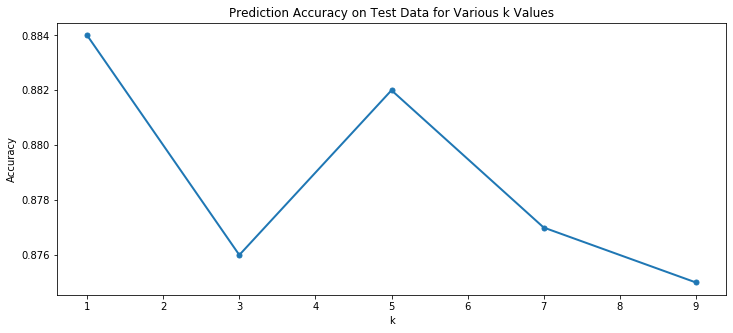

In [230]:
def P2(k_values):
    test_scores = []
    
    #iterate over k values
    for k in k_values:
        #create, train, and test a k-NN classifier, assume Euclidean distance metric
        classifier = KNeighborsClassifier(n_neighbors=k,p=2)
        trained_classifier = classifier.fit(mini_train_data,mini_train_labels)
        test_predictions = trained_classifier.predict(dev_data)
        
        #calculate prediction accuracies.
        num_labels = len(dev_labels)
        accuracy = 1 - sum(dev_labels != test_predictions)/num_labels
        test_scores.append(accuracy)
        
        #A classification report for each would be too verbose, so only do it for k = 1.
        if k == 1:
            print("Classification Report: k = 1")
            print(classification_report(dev_labels,test_predictions))
        
        print("k = %s, Test Accuracy = %s"%(k,accuracy))
    
    #plot accuracies against k-values
    plt.figure(figsize=(12,5))
    plt.plot(k_values,test_scores,linewidth = 2, marker = '.', markersize = 10, markevery =1)
    plt.ylabel('Accuracy')
    plt.xlabel('k')
    plt.title('Prediction Accuracy on Test Data for Various k Values')
    plt.show()
    
k_values = [1, 3, 5, 7, 9]
P2(k_values)

ANSWER:  
**Test Accuracy for all $k$ Values**  
The $k$ values selected for this model, 1, 3, 5, 7, and 9, all performed very similarly when considering only the Test Accuracy (total correct predictions divided by total number of predictions). The Test Accuracy for the models were all within one percent (1%) of each other. The worst performing $k$-value was 9, which had and accuracy of 87.5% and the best performing $k$-value was 1, which had an accuracy of 88.4%.

**Detailed Performance Analysis for $k = 1$**  
The 1-Nearest Neighbor Model performed the best overall for all values of $k$ in terms of Test Accuracy. Breaking that down, there are a few digits that were more difficult for the model: 2, 8, and 9, which had F1 scores of 0.84, 0.80, and 0.83, respectively. 

Examining each label individually:
* Digit 2 had a precision of 0.90 and a recall of 0.79 meaning that 90% of the data that it labeled as 2 were correct, but only 79% of the known labels of digit 2 were correct. 
* Digit 8 had a precision of 0.83 and a recall of 0.77, meaning that 83% of the data that it labeled as 8 were correct, but only 77% of the known labels of digit 8 were correct. 
* Digit 9 had a precision of 0.80 and a recall of 0.86, meaning that 80% of the data that it labeled as 9 were correct, but 86% of the known labels of digit 9 were correct.

Digit 8 had the lowest F1 score of these three digits and the lowest recall. Only 77% of cases were correct. Despite having a slightly higher precision than digit 9, the model's ability to accurately label the digit was much worse. Thus, 8 was the most difficult digit for the model.

### Part 3:

Produce 1-Nearest Neighbor models using training data of various sizes.  Evaluate and show the performance of each model.  Additionally, show the time needed to measure the performance of each model.

Notes:
* Train on the train set.
* Evaluate on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `time.time()` to measure elapsed time of operations.

Training Size: 100
Test Accuracy: 0.702000, Evaluation Time: 0.133907 sec
Training Size: 200
Test Accuracy: 0.791000, Evaluation Time: 0.234355 sec
Training Size: 400
Test Accuracy: 0.811000, Evaluation Time: 0.466280 sec
Training Size: 800
Test Accuracy: 0.866000, Evaluation Time: 1.028941 sec
Training Size: 1600
Test Accuracy: 0.905000, Evaluation Time: 1.716822 sec
Training Size: 3200
Test Accuracy: 0.927000, Evaluation Time: 3.432212 sec
Training Size: 6400
Test Accuracy: 0.939000, Evaluation Time: 6.948999 sec
Training Size: 12800
Test Accuracy: 0.952000, Evaluation Time: 14.052637 sec
Training Size: 25600
Test Accuracy: 0.963000, Evaluation Time: 30.161918 sec


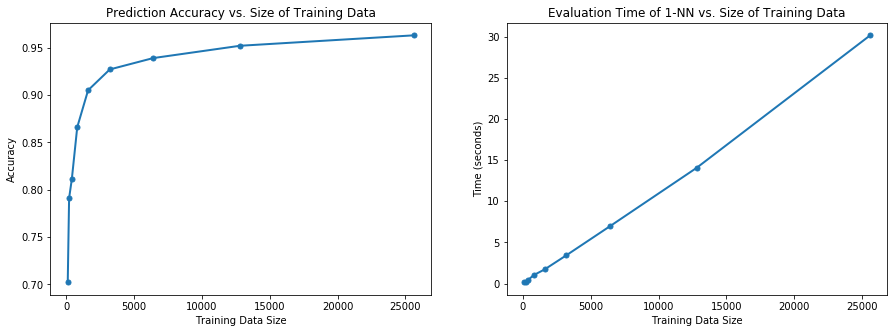

In [231]:
def P3(train_sizes, accuracies):
    times = []
    
    #initialize, train, and test a 1-NN model for each size in train_sizes
    for size in train_sizes: 
        
        #start a timer
        start = time.time()
        
        classifier = KNeighborsClassifier(n_neighbors = 1, p = 2)
        trained_classifier = classifier.fit(train_data[:size],train_labels[:size])
        test_predictions = trained_classifier.predict(dev_data)
        
        #calculate accuracy
        num_labels = len(dev_labels)
        accuracy = 1 - sum(dev_labels != test_predictions)/num_labels
        accuracies.append(accuracy)
        
        #finish timer
        end = time.time()
        elapsed_time = end - start
        times.append(elapsed_time)
        
        #report results
        print("Training Size: %s\nTest Accuracy: %2f, Evaluation Time: %2f sec"%(size,accuracy,elapsed_time))
        
    #plot accuracy results
    plt.figure(figsize =(15,5))
    plt.subplot(121)
    plt.plot(train_sizes,accuracies,linewidth = 2, marker = '.', markersize = 10)
    plt.ylabel('Accuracy')
    plt.xlabel('Training Data Size')
    plt.title('Prediction Accuracy vs. Size of Training Data')
    
    #plot timing results
    plt.subplot(122)
    plt.plot(train_sizes,times,linewidth = 2, marker = '.', markersize = 10)
    plt.ylabel('Time (seconds)')
    plt.xlabel('Training Data Size')
    plt.title('Evaluation Time of 1-NN vs. Size of Training Data')
    plt.show()
    
        
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
accuracies = []
P3(train_sizes, accuracies)

### Part 4:

Produce a regression model that predicts accuracy of a 1-Nearest Neighbor model given training set size. Show $R^2$ of the regression model and the accuracies it predicts for training set sizes 60000, 120000, and 1000000.  Show a lineplot of the actual accuracies and predicted accuracies vs. training set size.  What's wrong with using regression here?

Apply some transformation that makes the predictions more reasonable.  Show $R^2$ of the improved regression model and the accuracies it predicts for training set sizes 60000, 120000, and 1000000.  Show a lineplot of the actual accuracies and predicted accuracies vs. training set size.

Notes:
* Train the regression models on all of the (transformed) accuracies estimated in Problem 3.
* Evaluate the regression models on all of the (transformed) accuracies estimated in Problem 3.
* You can use `LinearRegression` to produce a linear regression model.
* Remember that the sklearn `fit()` functions take an input matrix X and output vector Y. So, each input example in X is a vector, even if it contains only a single value.

Model 1: Standard Linear Model:
Estimated function: y = 0.83 + 0.000007x
R-Squared: 0.417701
Accuracy Predictions for Training Set Sizes of 60000, 120000, and 1000000:
 [[1.23617317]
 [1.63742805]
 [7.52249967]]


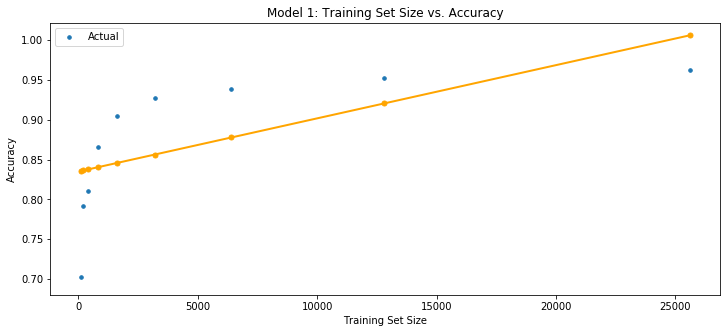

Model 2: Log-transformed Training Set Sizes
Estimated function: y = 0.55 + 0.044339log(x)
R-Squared: 0.906830
Accuracy Predictions for Training Set Sizes of 60000, 120000, and 1000000:
 [[1.03358792]
 [1.06432125]
 [1.15833125]]


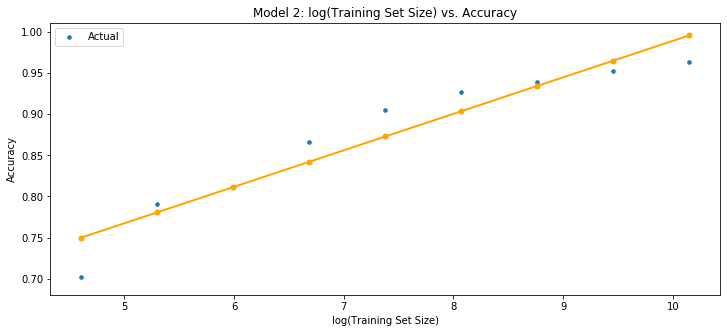

Model 3: Log-transformed training sizes and odds-transformed accuracies:
Estimated function: odds(y) = -19.23 + 4.118222log(x)
R-Squared: 0.939524
Odds(accuracy) Predictions for Training Set Sizes of 60000, 120000, and 1000000:
 [[26.07837794]
 [28.93291195]
 [37.66462802]]
Odds(accuracy) predictions converted to accuracies:
 [[0.96307017]
 [0.96659196]
 [0.97413657]]


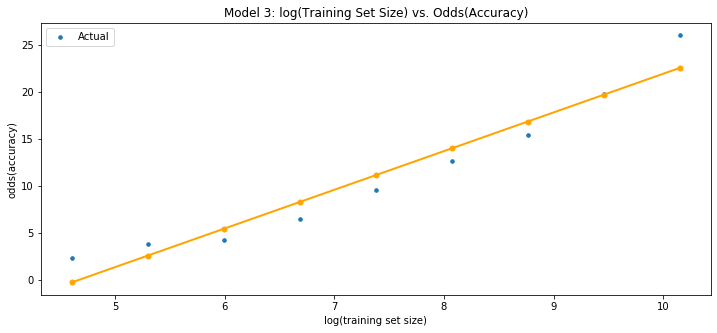

In [232]:
def P4():
    #training set sizes and accuracies from problem 3
    #each array is reshapes to a 2D vector for use by sklearn
    train_sizes = np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]).reshape(-1,1)
    accuracies = np.array([0.702, 0.791, 0.811, 0.866, 0.905, 0.927, 0.939, 0.952, 0.963]).reshape(-1,1)
    
    #initialize, fit, score, and predict a linear regression model
    model = LinearRegression()
    fitted_model = model.fit(train_sizes, accuracies)
    fitted_model_r_sq = fitted_model.score(train_sizes,accuracies)
    predictions = fitted_model.predict(train_sizes)
    
    #report results
    print('Model 1: Standard Linear Model:')
    print('Estimated function: y = %.2f + %8fx' %(fitted_model.intercept_, fitted_model.coef_[0]))
    print('R-Squared: %2f'%fitted_model_r_sq)
    
    #training set sizes we want to predict, reshaped in the same manner as above
    sizes_to_predict = np.array([60000,120000,1000000]).reshape(-1,1)
    addl_predictions = fitted_model.predict(sizes_to_predict)
    print('Accuracy Predictions for Training Set Sizes of 60000, 120000, and 1000000:\n',addl_predictions)
    
    #Plotting the model
    fig1 = plt.figure(figsize = (12,5))
    fig1_actual = plt.scatter(train_sizes,accuracies, marker = '.', s=50)
    fig1_predict = plt.plot(train_sizes,predictions,linewidth = 2, marker = '.', markersize = 10, color = 'orange')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Model 1: Training Set Size vs. Accuracy')
    plt.legend([fig1_actual],['Actual'])
    plt.show()
    
    
    #Modeling the data with a non-transformed linear model does not yield the best results
    #Transform the data by taking the natural log of the training set size.
    log_train_sizes = np.log(train_sizes)
    log_model = LinearRegression()
    fitted_log_model = log_model.fit(log_train_sizes, accuracies)
    fitted_log_model_r_sq= fitted_log_model.score(log_train_sizes, accuracies)
    
    log_predictions = fitted_log_model.predict(log_train_sizes)
    print('Model 2: Log-transformed Training Set Sizes')
    print('Estimated function: y = %.2f + %8flog(x)' %(fitted_log_model.intercept_, fitted_log_model.coef_[0]))
    print('R-Squared: %2f'%fitted_log_model_r_sq)
    
    #Predicting the additional training set sizes. Transforming them with a natural log first.
    log_sizes_to_predict = np.log(sizes_to_predict)
    addl_log_predictions = fitted_log_model.predict(log_sizes_to_predict)
    print('Accuracy Predictions for Training Set Sizes of 60000, 120000, and 1000000:\n',addl_log_predictions)
    
    #Plotting the model
    fig2 = plt.figure(figsize = (12,5))
    fig2_actual = plt.scatter(log_train_sizes,accuracies, marker = '.', s=50)
    fig2_predict = plt.plot(log_train_sizes,log_predictions,linewidth = 2, marker = '.', markersize = 10,color = 'orange')
    plt.xlabel('log(Training Set Size)')
    plt.ylabel('Accuracy')
    plt.title('Model 2: log(Training Set Size) vs. Accuracy')
    plt.legend([fig2_actual],['Actual'])
    plt.show()
              
              
    #The results are much better for the log-transformed training sizes, but we still end up with
    #accuracies >1 in the predictions, which is not possilble. Transform the outcome variable to odds.
    #Essentially, accuracy is the probability that the model will get something right. Transforming to odds
    #will give us that odds accuracy, the odds that the model predicts something right.
    odds_accuracies = np.array([y/(1-y) for y in accuracies]).reshape(-1,1)
    odds_log_model = LinearRegression()
    fitted_odds_log_model = odds_log_model.fit(log_train_sizes,odds_accuracies)
    fitted_odds_log_model_r_sq = fitted_odds_log_model.score(log_train_sizes,odds_accuracies)
    
    odds_log_predictions = fitted_odds_log_model.predict(log_train_sizes)
    print('Model 3: Log-transformed training sizes and odds-transformed accuracies:')
    print('Estimated function: odds(y) = %.2f + %8flog(x)' %(fitted_odds_log_model.intercept_, fitted_odds_log_model.coef_[0]))
    print('R-Squared: %2f'%fitted_odds_log_model_r_sq)
    
    #Predicting the additional training set sizes. Transforming the accuracies first
    addl_odds_log_predictions = fitted_odds_log_model.predict(log_sizes_to_predict)
    print('Odds(accuracy) Predictions for Training Set Sizes of 60000, 120000, and 1000000:\n',addl_odds_log_predictions)
    #Converting odds(accuracy) back to accuracy to gut check.
    oa_to_a = np.array([o/(1+o) for o in addl_odds_log_predictions]).reshape(-1,1)
    print('Odds(accuracy) predictions converted to accuracies:\n',oa_to_a )
    
    fig3 = plt.figure(figsize = (12,5))
    fig3_actual = plt.scatter(log_train_sizes,odds_accuracies, marker = '.', s = 50)
    fig3_predict = plt.plot(log_train_sizes,odds_log_predictions,linewidth = 2, marker = '.', markersize = 10, color = 'orange')
    plt.xlabel('log(training set size)')
    plt.ylabel('odds(accuracy)')
    plt.title('Model 3: log(Training Set Size) vs. Odds(Accuracy)')
    plt.legend([fig3_actual],['Actual'])
    plt.show()
P4()

ANSWER:

**Model 1: Simple Linear Model**
The first model uses simple linear regression with the predictor variable being training set size ($x$) and the outcome variable being model accuracy ($y$). Fitting this model resulting in the following equation: $y = 0.83 + 0.000007x$. The $R^2$ for this model is 0.417. Plotting the regression line against the data exposes two issues with using a simple linear model for this scenario: (1) The data clearly demonstrate a non-linear relationship between training set size and model accuracy, as depicted by the resulting $R^2$; and (2) given the linear trend line of the model, the predicted accuracy will at some point be greater than 1, which is not possible because accuracy = 1 when all labels are predicted correctly. The latter issue becomes clear when examining the predicted accuracies for training set sizes of 60,000, 120,000, and 1,000,000, which are 1.24, 1.64, and 7.52, respectively.

**Model 2: Log-transformed Training Set Sizes**
To take care of the first issue in Model 1, Model 2 integrates a log-transformation to the predictor variable, training set size. Such a transformation may help linearize the data and provide a better fit of the model to the data. Fitting this model resultied in the following equation: $y = 0.55 + 4.118\cdot \log(x)$. The $R^2$ for this model is 0.906. The transformation increased the $R^2$ substantially, but there is still an issue with the accuracy. Predicted accuracy values for larger training set sizes can still be greater than 1. The predictions for the additional training set sizes, 60,000, 120,000, and 1,000,000, were 1.03, 1.06, and 1.16, respectively. Those these results are much better than Model 1, a transformation to the outcome, accuracy may eliminate this issue.

**Model 3: Log-transformed Training Set Sizes and Odds-transformed Accuracies**  
Model 3 builds off of Model 2 by transforming the accuracies to odds. Conceptualizing accuracy as the probability that the model will predict the correct label, odds instead expresses the likelihood that the model will predict the correct label. The equation for odds is: $Odds(y_i) = \frac{y_i}{1-y_i}$ where $i$ is a given accuracy from the data. Fitting the model to the data using odds and the log-transformed training set sizes, the resulting equation is: $Odds(y) = -19.23 + 4.12\cdot \log(x)$ The $R^2$ for this model is 0.94. Predicting the odds(accuracy) for each of the additional training set sizes, 60,000, 120,000, and 1,000,000, yields 26.1, 28.9, and 37.7. Converting these odds back to accuracies via the equation $y_i = \frac{Odds(y_i)}{1 + Odds(y_i)}$ results in accuracies for the additional training set sizes of 0.963, 0.967, and 0.974.



### Part 5:

Produce a 1-Nearest Neighbor model and show the confusion matrix. Which pair of digits does the model confuse most often? Show the images of these most often confused digits.

Notes:
- Train on the mini train set.
- Evaluate performance on the dev set.
- You can use `confusion_matrix()` to produce a confusion matrix.

Confusion Matrix for 1-NN Model Trained on mini_train Set:
 [[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]


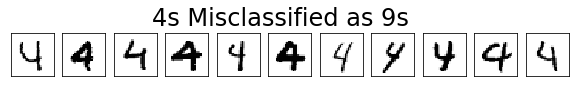

In [233]:
def P5():
    #initialize, train and test a 1-NN model
    classifier = KNeighborsClassifier(n_neighbors = 1, p = 2)
    trained_classifier = classifier.fit(mini_train_data,mini_train_labels)
    test_predictions = trained_classifier.predict(dev_data)
    
    #Display confusion matrix
    print("Confusion Matrix for 1-NN Model Trained on mini_train Set:\n",\
          confusion_matrix(dev_labels,test_predictions,labels=["0","1","2","3","4","5","6","7","8","9"]))
    misclassified_indices = [index for index in range(len(dev_data)) if dev_labels[index] == "4" and test_predictions[index] == "9"]
    
    #Display array of 4s misclassified as 9s
    fig, axes = plt.subplots(1,11,figsize = (10,3))
    fig.suptitle('4s Misclassified as 9s',fontsize = 24, y = 0.725)
    
    #iterate through each misclassfied "4"
    for i in range(11):
        #reshape the indicated index in the training data and add it to the figure
        axes[i].imshow(dev_data[misclassified_indices[i]].reshape(28,28), cmap = 'Greys')
        # remove the tick marks and labels for each plot as they are irrelevant for just displaying examples
        axes[i].get_xaxis().set_ticks([])
        axes[i].get_yaxis().set_ticks([])
    plt.show()
    
P5()

ANSWER:  
The most common misclassification in the dev_data test set was the digit 4 being confused as digit 9. A total of 11 of these misclassifications took place.

### Part 6:

A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.

Apply your blur filter in 3 ways:
- Filter the training data but not the dev data
- Filter the dev data but not the training data
- Filter both training data and dev data

Show the accuracy resulting from not using any filter and from each way you apply the filter.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* There are Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but you are likely to get the best results with the simplified version described above.

In [4]:
def P6():
    def gaussian_kernel(blur_factor):
        '''
        Create a Gaussian Blur kernel for a specific blur factor.
        Assumes a 3x3 filter.
        Input(s): 
            - blur_factor (float): this number makes the image smoother(blurrier) as it increases
        Output(s): returns a 3x3 np.array
        '''
        #calculate the constant that will be multiplied for all weights
        c = (1/(2*np.pi*(blur_factor**2)))
        
        #calculate the denominator for the exponent of each weight
        e_d = (2*(blur_factor**2))
        
        #generate the exponents for each weight, the numerator is the sum of squares of the x and y
        #distances away from the center of the matrix
        exponent = np.array([[-(2/e_d),-(1/e_d), -(2/e_d)],\
                           [-(1/e_d),-(0/e_d),-(1/e_d)],\
                           [-(2/e_d),-(1/e_d),-(2/e_d)]])
        
        #calculate the initial weights: w = c*e^(exponent)
        weights = c*np.exp(exponent)
        
        #weights do not add up to 1, so we need to multiply them by a factor of 1/sum(weights) to get a kernel
        kernel = (1/np.sum(weights))*weights
        
        return kernel
    
    def get_pixel_value(row, col, matrix):
        '''
        Returns the value at the specified row and column in the given matrix.
        Input(s):
            - row(int): row in the supplied matrix
            - col(int): column in the supplied matrix
            - matrix(np.array): matrix
        Output(s):
            - If coordinates are valid for the matrix, returns the value at those coordinates
            - If coordinates are not valid for the matrix, returns 0
        '''
        shape = matrix.shape
        #return 0 if neither of the coordinates are valid in any way
        if row < 0 or row >= shape[0] or col < 0 or col >= shape[1]:
            return 0
        else:
            return matrix[row,col]
        
    def apply_blur(image,blur_factor, shape = (28,28)):
        '''
        Blurs an image using the specified blur factor.
        Input(s): 
            - image(np.array): image to blur as a 1d array
            - blur_factor(float): specified degree to blur the image
            - shape(tuple): (height, width) of the image. Defaults to 28x28
        Output(s): returns a blurred image as a 1d np.array
        '''
        #first create a kernel to use
        kernel = gaussian_kernel(blur_factor)
        #reshape the 1d image
        i = image.reshape(shape[0],shape[1])
        #make a copy of the image
        blurred_image = np.copy(i)
        for m in range(shape[0]):
            for n in range(shape[1]):
                # get the value of pixel m, n and all surrounding pixels
                pixel_values = np.array([[get_pixel_value(m-1,n-1,i),get_pixel_value(m-1,n,i),get_pixel_value(m-1,n+1,i)],\
                                         [get_pixel_value(m,n-1,i),get_pixel_value(m,n,i),get_pixel_value(m,n+1,i)],\
                                         [get_pixel_value(m+1,n-1,i),get_pixel_value(m+1,n,i),get_pixel_value(m+1,n+1,i)]])
                #multiply pixel values by the kernel weights, this works because we are treating the matrix as an array
                weighted_values = pixel_values*kernel
                #take the sum of the weighted values and apply it to the copy of the image to blur it
                blurred_image[m,n] = np.sum(weighted_values)
        #return the blurred image as a 1d array
        return blurred_image.reshape(shape[0]*shape[1])

    filtered_training_data = np.array([apply_blur(i,10) for i in train_data])
    filtered_dev_data = np.array([apply_blur(j,10) for j in dev_data])
    
    #1-NN model instantiation with no filter and filter
    no_filter_classifier = KNeighborsClassifier(n_neighbors = 1, p = 2)
    filter_train_classifier = KNeighborsClassifier(n_neighbors = 1, p = 2)
    
    #train with no filters
    no_filter_trained = no_filter_classifier.fit(train_data,train_labels)
    
    #train with filtered training data 
    filter_train_trained = filter_train_classifier.fit(filtered_training_data,train_labels)
    
    #predict with no filters on either train or test
    no_filter_predictions = no_filter_trained.predict(dev_data)
    
    #predict with filter on train only
    filter_train_predictions = filter_train_trained.predict(dev_data)
    
    #predict with filtered test only
    filter_dev_predictions = no_filter_trained.predict(filtered_dev_data)
    
    #predict with both train and test filtered
    filter_both_predictions = filter_train_trained.predict(filtered_dev_data) 
    
    #calculate accuracies
    num_labels = len(dev_labels)
    accuracy_no_filter = 1 - sum(dev_labels != no_filter_predictions)/num_labels
    accuracy_filter_train = 1 - sum(dev_labels != filter_train_predictions)/num_labels
    accuracy_filter_dev = 1 - sum(dev_labels != filter_dev_predictions)/num_labels
    accuracy_filter_both = 1 - sum(dev_labels != filter_both_predictions)/num_labels
    
    print('Accuracy (No Filters): %2f'%accuracy_no_filter)
    print('Accuracy (Filter on Training Data Only): %2f'%accuracy_filter_train)
    print('Accuracy (Filter on Test Data Only): %2f'%accuracy_filter_dev)
    print('Accuracy (Filter on Both Train and Test Data): %2f'%accuracy_filter_both)
    
        
P6()

Accuracy (No Filters): 0.971000
Accuracy (Filter on Training Data Only): 0.976000
Accuracy (Filter on Test Data Only): 0.971000
Accuracy (Filter on Both Train and Test Data): 0.977000


### Part 7:

Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.

For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter.  Use some reasonable threshold to separate white from black.  Use `BernoulliNB` to produce the model.

For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data.  Use some reasonable thresholds to separate white from gray from black.  Use `MultinomialNB` to produce the model. 

Show the Bernoulli model accuracy and the Multinomial model accuracy.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* `sklearn`'s Naive Bayes methods can handle real numbers, but for this exercise explicitly do the mapping to categoricals. 

Does the multinomial version improve the results? Why or why not?

In [235]:
def P7():
    
    def binarize_data(threshold,data):
        '''
        Converts data on a continous [0,1] scale to discrete binary values [0 OR 1]
        Input(s):
            - threshold (float): The threshold value such that values <= threshold will be 0
                                 and values > threshold will be 1.
            - data (array): array object containing data where each value is on a continuous [0,1] scale
        Outputs(s): returns np.array object containing binarized data
        '''
        return np.array([0 if i <= threshold else 1 for i in data])
        
    
    def trinarize_data(threshold_1,threshold_2,data):
        '''
        Converts data on a continous [0,1] scale to discrete ternary values [0 OR 1 OR 2]
        Input(s):
            - threshold_1 (float): The threshold value such that values <= threshold_1 will be 0
            - threshold_2 (float): The threshold value such that values <= threshold_2 will be 1.
                                   Applied secondarily if threshold_1 not met. A value not meeting
                                   threshold_2 becomes 2.
            - data (array): array object containing data where each value is on a continuous [0,1] scale
        Outputs(s): returns np.array object containing trinarized data
        '''
        return np.array([0 if i <= threshold_1 else 1 if i <= threshold_2 else 2 for i in data])
    
    #Apply binarization and trinarization functions defined above to mini_train_data and dev_data
    #For binary data, the 0/1 split is halfway through the range, 0.5
    binarized_train = np.array([binarize_data(0.5,d) for d in mini_train_data])
    binarized_test = np.array([binarize_data(0.5,d) for d in dev_data])
    
    #For ternary data, the range is split into thirds
    trinarized_train = np.array([trinarize_data(0.333,0.666,d) for d in mini_train_data])
    trinarized_test = np.array([trinarize_data(0.333,0.666,d) for d in dev_data])
    
    #Initialize, train, and test the Bernoulli Naive Bayes Classifier
    bernoulli_classifer = BernoulliNB()
    trained_bernoulli_classifier = bernoulli_classifer.fit(binarized_train,mini_train_labels)
    bernoulli_predictions = trained_bernoulli_classifier.predict(binarized_test)
    
    #Initialize, train, and test the Multinomial Naive Bayes Classifier
    multi_classifier = MultinomialNB()
    trained_multi_classifier = multi_classifier.fit(trinarized_train,mini_train_labels)
    multi_predictions = trained_multi_classifier.predict(trinarized_test)
    
    #Calculate and report accuracies
    num_labels = len(dev_labels)
    accuracy_bernoulli = 1 - sum(dev_labels != bernoulli_predictions)/num_labels
    accuracy_multi = 1 - sum(dev_labels != multi_predictions)/num_labels
    print('Accuracy (Bernoulli): %2f'%accuracy_bernoulli)
    print('Accuracy (Multinomial): %2f'%accuracy_multi)
    
P7()

Accuracy (Bernoulli): 0.819000
Accuracy (Multinomial): 0.815000


ANSWER:  
The multinomial approach does not improve the accuracy over the Bernoulli approach. In the Bernoulli approach, we are simply modeling the pixels in each image as on or off and looking at the probabilities that each of those pixels is on given a class (digit). With handwriting there is a sharp boundary between what constitutes as part of a written digit and what does not constitute as part of a written. Thus, there are few pixels that would be somewhere between on and off. The multinomial approach attempts to add a third component of the feature vector to the decision space in a scenario where classification is primarily binary. The third component, "grey," does not help much when classifying handwriting, so it does not increase the accuracy of the model. In the test here, it made the model worse by a very small amount.  

### Part 8:

Search across several values for the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.

Notes:
* Train on the mini train set.
* Vary alpha and evaulate performance using `GridSearchCV` to cross-validate.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you used the dev set to evaluate performance.

What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

/Users/nick/.venvs/W207/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Alpha = 1e-10 -> Accuracy = 0.813
Alpha = 0.0001 -> Accuracy = 0.821
Alpha = 0.001 -> Accuracy = 0.825
Alpha = 0.01 -> Accuracy = 0.82
Alpha = 0.1 -> Accuracy = 0.818
Alpha = 0.5 -> Accuracy = 0.816
Alpha = 1.0 -> Accuracy = 0.811
Alpha = 2.0 -> Accuracy = 0.805
Alpha = 10.0 -> Accuracy = 0.781


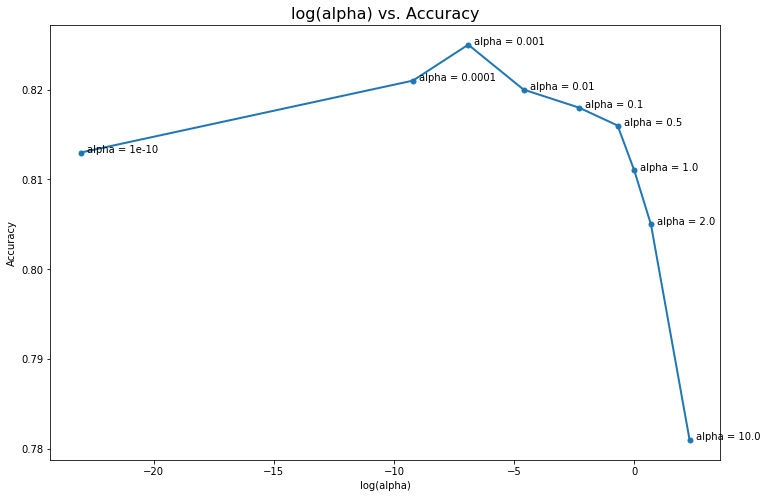

Class: 0, Number of Occurences: 91
Class: 1, Number of Occurences: 96
Class: 2, Number of Occurences: 91
Class: 3, Number of Occurences: 103
Class: 4, Number of Occurences: 97
Class: 5, Number of Occurences: 84
Class: 6, Number of Occurences: 106
Class: 7, Number of Occurences: 116
Class: 8, Number of Occurences: 123
Class: 9, Number of Occurences: 93

Best alpha =  {'alpha': 0.001}


In [236]:
def P8(alphas):
    #initialize a Bernoulli Naive Bayes clissifier
    classifier = BernoulliNB()
    #set up cross validation
    grid_search = GridSearchCV(estimator = classifier,param_grid = alphas, scoring = 'accuracy', cv = 5)
    #run cross validation on mini_train_data
    grid_search_results = grid_search.fit(mini_train_data,mini_train_labels)
    accuracies = grid_search.cv_results_['mean_test_score']
    
    #log transform alphas for better plotting
    log_alphas = np.log(alphas['alpha'])
    
    #plot results
    fig = plt.figure(figsize=(12,8))
    plt.plot(log_alphas,accuracies, marker = '.', markersize = 10,linewidth=2)
    for i,alpha in enumerate(alphas['alpha']):
        print('Alpha = %s -> Accuracy = %s'%(alpha,accuracies[i]))
        plt.annotate('alpha = %s'%alpha,(log_alphas[i]+0.25,accuracies[i]))
    plt.xlabel('log(alpha)')
    plt.ylabel('Accuracy')
    plt.title('log(alpha) vs. Accuracy',fontsize=16)
    plt.show()
    
    
    #get the counts for each label in the dataset, useful for interpreting results of cross validation
    class_count = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}
    for label in mini_train_labels:
            class_count[label] += 1
            
    for cls, cnt in class_count.items():
        print('Class: %s, Number of Occurences: %s'%(cls,cnt))
    
    return grid_search

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)
print()
print("Best alpha = ", nb.best_params_)

ANSWER:  
Overall, accuracies for a Bernoulli Naive Bayes Model on non-binarized data with varying alpha parameters were all within 5% of each other. *The best alpha was 0.001* with an accuracy of 0.825, followed very closely by 0.0001 and 0.011 with accuracies of 0.821 and 0.82, respectively. Accuracies near zero were the best for this model and data except for alpha = 1e-10, which is the closest to 0 and had an accuracy of 0.813, slightly worse than the alphas a litte bit further away.  
  
Higher accuracies with smaller alphas are what I would expect for this dataset because there are numerous examples of each class. The distribution of the number of classes, while not perfectly uniform, is probably uniform enough that Laplace smoothing does not help the model's accuracy all that much.

### Part 9:

Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. Diagnose the problem and apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. Show the model accuracy before your fix and the model accuracy after your fix.  Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Consider the effects of theta and sigma.  These are stored in the model's `theta_` and `sigma_` attributes.

In [237]:
def P9():
    
    #Initialize Gaussian Naive Bayes classifier, train on mini_train_data and test on dev_data
    classifier = GaussianNB()
    trained_classifier = classifier.fit(mini_train_data, mini_train_labels)
    predictions = trained_classifier.predict(dev_data)
    accuracy = 1 - sum(predictions != dev_labels)/len(dev_labels)
    
    #Reporting results
    print('Model Accuracy - Gaussian Naive Bayes (default parameters): %2f'%accuracy)
    print('Range of feature means:%f - %f'%(np.min(trained_classifier.theta_),np.max(trained_classifier.theta_)))
    print('Range of feature variances:%f - %f'%(np.min(trained_classifier.sigma_),np.max(trained_classifier.sigma_)))
    print('Absolute additive value for each variance, epsilon: %f'%trained_classifier.epsilon_)
    
    #calculate variances without additive value, epsilon
    t_c_new_var = trained_classifier.sigma_ - trained_classifier.epsilon_
    print('Range of feature variances less epsilon: %f - %f\n'%(np.min(t_c_new_var),np.max(t_c_new_var)))
    
    #Using an updated variance smoothing factor of 0.1, initialize, train, and test a new Gaussian Naive Bayes model
    adj_classifier = GaussianNB(var_smoothing = 0.1)
    trained_adj_classifier = adj_classifier.fit(mini_train_data, mini_train_labels)
    new_predictions = trained_adj_classifier.predict(dev_data)
    new_accuracy = 1 - sum(new_predictions != dev_labels)/len(dev_labels)
    
    #Reporting results
    print('Model Accuracy - Gaussian Naive Bayes (var_smoothing = 0.1): %2f'%(new_accuracy))
    print('Range of feature means:%f - %f'%(np.min(trained_adj_classifier.theta_),np.max(trained_adj_classifier.theta_)))
    print('Range of feature variances:%f - %f'%(np.min(trained_adj_classifier.sigma_),np.max(trained_adj_classifier.sigma_)))
    print('Absolute additive value for each variance, epsilon: %f'%trained_adj_classifier.epsilon_)
    
    #calculate variances without additive value, epsilon
    t_a_c_new_var = trained_adj_classifier.sigma_ - trained_adj_classifier.epsilon_
    print('Range of feature variances less epsilon: %f - %f\n'%(np.min(t_a_c_new_var),np.max(t_a_c_new_var)))
    
P9()

Model Accuracy - Gaussian Naive Bayes (default parameters): 0.593000
Range of feature means:0.000000 - 0.961234
Range of feature variances:0.000000 - 0.212064
Absolute additive value for each variance, epsilon: 0.000000
Range of feature variances less epsilon: 0.000000 - 0.212064

Model Accuracy - Gaussian Naive Bayes (var_smoothing = 0.1): 0.817000
Range of feature means:0.000000 - 0.961234
Range of feature variances:0.020143 - 0.232208
Absolute additive value for each variance, epsilon: 0.020143
Range of feature variances less epsilon: 0.000000 - 0.212064



ANSWER:  
The `var_smoothing` hyperparameter for the Gaussian Naive Bayes classifer dictates a number (which is the value given for the parameter multiplied by the max variance of all feature-class combinations) to add to all of the variances (sigma) of the Gaussian distributions representing each feature-class combination.  
  
In this application, each feature is a pixel, and one can imagine that the feature distributions are biased because the individual pixels representing handwriting are implicitly binary (or very close to it). A pixel is representative of a location on paper and for a handwritten digit, there is either a mark there or there isn't. Most of the variation we see for a specific pixel, regardless of the digit, is due to the pressure applied by the pen on the paper to make the mark. The inherent concentration of marked paper versus unmarked paper for a digit biases the possible range of values any pixel can take on, leading to very small variances.  
  
Variance smoothing widens out the distributions for each feature-class combination, allowing for more flexibility when presented new data to classify. That flexibility is necessary for accurate prediction in the case of handwriting because of how variable handwriting can be. I suspect that the key features defining digit classification are more regional, thus variance smoothing is a preventative measure for reducing overfitting.  
  
For this model, smoothing the variance by a small amount was enough to improve the accuracy to close to that of a Bernoulli Naive Bayes Classifier. I attempted larger amounts of smoothing, but accuracy went down instead, likely because variances became too large to distinguish specific digits. 

### Part 10:

Because Naive Bayes produces a generative model, you can use it to generate digit images.

Produce a Bernoulli Naive Bayes model and then use it to generate a 10x20 grid with 20 example images of each digit. Each pixel output should be either 0 or 1, based on comparing some randomly generated number to the estimated probability of the pixel being either 0 or 1.  Show the grid.

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.

How do the generated digit images compare to the training digit images?

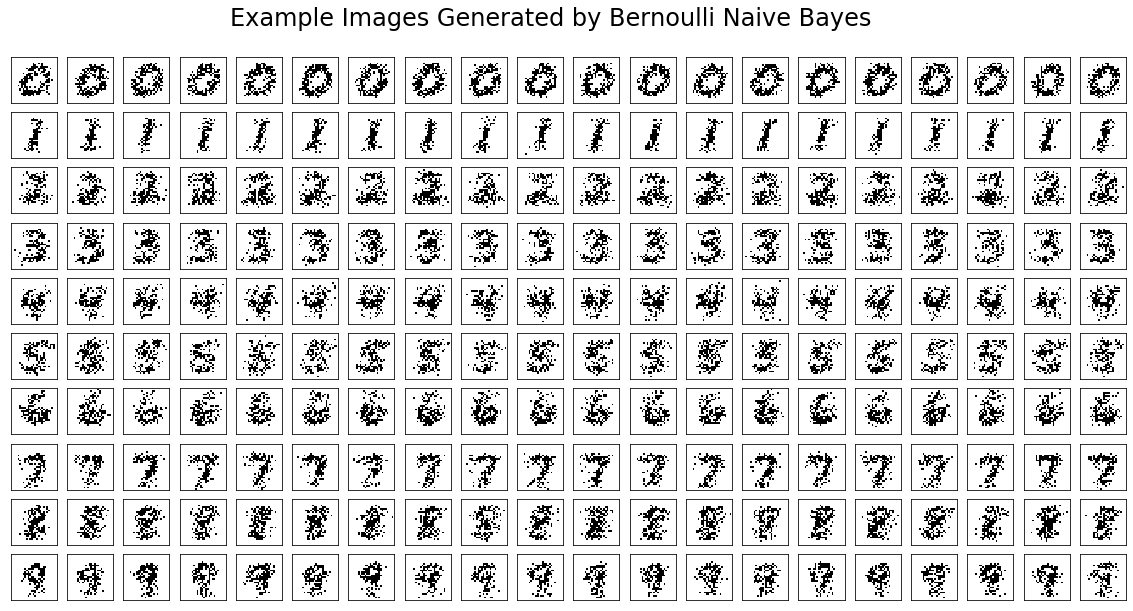

In [238]:
def P10(num_examples):
    #initialize a Bernoulli Naive Bayes Classifer and fit it to training data
    classifier = BernoulliNB(alpha = 0.001,binarize = 0.3)
    trained_classifier = classifier.fit(train_data,train_labels)
    
    #convert the log probabilities for each feature for each class
    probabilities = np.exp(trained_classifier.feature_log_prob_)
    
    #initialize plot setup
    fig = plt.figure(figsize = (20,10))
    plot_id = 1
    fig.suptitle('Example Images Generated by Bernoulli Naive Bayes', fontsize = 24, y = .95)
    
    #iterate over each class
    for i in range(10):
        #iterate for the number of examples we want to generate for each class
        for j in range(20):
            plt.subplot(10,20,plot_id)
            #sample a uniform distribution over [0,1] the same number of times as there are pixels 
            random_numbers = np.random.rand(784,)
            #generate the sample by assigning the value of 1 for a pixel if its value is less then or equal
            #to the probability that a pixel has the value of 1 in the training data. Otherwise, assign 0
            example = np.array([1 if random_numbers[k] <= probabilities[i][k] else 0 for k in range(784)])
            #show the example
            plt.imshow(example.reshape(28,28), cmap = 'Greys')
            plt.xticks([])
            plt.yticks([])
            plot_id +=1
    
    plt.show()

P10(20)

ANSWER:  
The digit examples produced by the Naive Bayes model are far noisier than the training digit images, though still recognizable. 

### Part 11:

Recall that a strongly calibrated classifier is roughly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior probability of the predicted class is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior probability and accuracy.  

Produce a Bernoulli Naive Bayes model.  Evaluate performance: partition the dev set into several buckets based on the posterior probabilities of the predicted classes - think of a bin in a histogram- and then estimate the accuracy for each bucket. So, for each prediction, find the bucket to which the maximum posterior probability belongs, and update "correct" and "total" counters accordingly.  Show the accuracy for each bucket.

Notes:
* Train on the mini train set.
* Evaluate perfromance on the dev set.
* Apply a reasonable Laplace smoothing (alpha) value.

How would you characterize the calibration for this Bernoulli Naive Bayes model?

In [239]:
def P11(buckets, correct, total):
    
    #Initialize Bernoulli Naive Bayes classifier. Selected alpha parameter is best performer from P8()
    classifier = BernoulliNB(alpha = 0.01)
    trained_classifier = classifier.fit(mini_train_data,mini_train_labels)
    #get the posterior probabilities for each class for every item in the test set
    predicted_probabilities = trained_classifier.predict_proba(dev_data)
    #predict on test data and create an array defining whether or not the prediction was correct
    predicted_classes = trained_classifier.predict(dev_data)
    prediction_correct = predicted_classes == dev_labels
    
    #iterate over all the predicted probability arrays
    for i in range(len(predicted_probabilities)):
        #find the max posterior probability the array and iterate to find its bucket.
        max_prob = np.max(predicted_probabilities[i])
        bucket = 0
        for b in buckets:
            if max_prob > b:
                bucket += 1
            else:
                break
        #advance total count and correct count when necessary
        total[bucket] += 1
        if prediction_correct[i]:
            correct[bucket] += 1
    
buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) is %.13f to %.13f    total = %3d    accuracy = %.3f' % (0 if i==0 else buckets[i-1], buckets[i], total[i], accuracy))

p(pred) is 0.0000000000000 to 0.5000000000000    total =   0    accuracy = 0.000
p(pred) is 0.5000000000000 to 0.9000000000000    total =  30    accuracy = 0.333
p(pred) is 0.9000000000000 to 0.9990000000000    total =  72    accuracy = 0.431
p(pred) is 0.9990000000000 to 0.9999900000000    total =  59    accuracy = 0.508
p(pred) is 0.9999900000000 to 0.9999999000000    total =  51    accuracy = 0.667
p(pred) is 0.9999999000000 to 0.9999999990000    total =  53    accuracy = 0.792
p(pred) is 0.9999999990000 to 0.9999999999900    total =  35    accuracy = 0.743
p(pred) is 0.9999999999900 to 0.9999999999999    total =  46    accuracy = 0.761
p(pred) is 0.9999999999999 to 1.0000000000000    total = 654    accuracy = 0.942


ANSWER:  
This Bernoulli Naive Bayes model is very weakly calibrated. In general, the accuracy goes up with the posterior probability. However, there is some noise for three bins: 0.9999999000000 to 0.9999999990000, 0.9999999990000 to 0.9999999999900, and 0.9999999999900 to 0.9999999999999. The noise for these bins may be in part due to the variability in the total number of examples in each bin as well as the fact that their ranges are very close together. The third bin of these three has a sample size of 46, which is roughly the average of the other two sample sizes, and an accuracy of 0.761, which is also roughly the average of the other two accuracies.  
  
These results also demonstrate the general overconfidence Naive Bayes expresses because the accuracies are lower than the posterior probabilities in all cases.

### Part 12 EXTRA CREDIT:

Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.  Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try counting the number of enclosed regions. (8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0)

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [240]:
def P12():
    #Binarize train and test data. Code used here is a compacted version of that used in Problem 7
    bin_threshold = 0.3
    binarized_train = np.array([np.array([0 if i <= bin_threshold else 1 for i in j]) for j in mini_train_data])
    binarized_test = np.array([np.array([0 if i <= bin_threshold else 1 for i in j]) for j in dev_data])
    
    #Baseline model: initialize, train, and test.
    baseline_classifier = BernoulliNB(alpha = 0.001)
    trained_baseline_classifier = baseline_classifier.fit(binarized_train,mini_train_labels)
    baseline_predictions = trained_baseline_classifier.predict(binarized_test)
    
    #Report baseline Results:
    print('Results: Baseline Model (alpha = 0.001, binarization threshold = %2f)'%bin_threshold)
    print('Accuracy: %2f'%(1 - sum(dev_labels != baseline_predictions)/len(dev_labels)))
    print('Classification Report: ')
    print(classification_report(dev_labels,baseline_predictions, labels = ['0','1','2','3','4','5','6','7','8','9']))
    
    #Let's try creating some features representing the sum of each row, define a function to do this:
    def rowsum(data):
        #instantiate an empty array
        rowsum_data= np.array([])
        for i in range(len(data)):
            
            #reshape digit to 28x28
            digit = data[i].reshape(28,28)
            
            #create an array of the sums of the rows
            rowsum = np.sum(digit,axis=1)
            
            #add the original digit back as its 1d self to the empty array
            rowsum_data = np.append(rowsum_data,digit.reshape(784,1))
            #add the new sum features to the digit
            rowsum_data = np.append(rowsum_data,rowsum)
   
        #reshape the data to separate out the pixel features and rowsum features for each digit
        rowsum_data = rowsum_data.reshape(len(data),812)
        return rowsum_data
    
    #add rowsum features to train and test
    rowsum_binarized_train = rowsum(binarized_train)
    rowsum_binarized_test = rowsum(binarized_test)
      
    #Rowsum model: initialize, train, and test. 
    rowsum_classifier = BernoulliNB(alpha = 0.001)
    trained_rowsum_classifier = rowsum_classifier.fit(rowsum_binarized_train,mini_train_labels)
    rowsum_predictions = trained_rowsum_classifier.predict(rowsum_binarized_test)
    
    #Report Row-Sum Results:
    print('Results: Row-Sum Model (alpha = 0.001, binarization threshold = %2f)'%bin_threshold)
    print('Accuracy: %2f'%(1 - sum(dev_labels != rowsum_predictions)/len(dev_labels)))
    print('Classification Report: ')
    print(classification_report(dev_labels,rowsum_predictions, labels = ['0','1','2','3','4','5','6','7','8','9']))
    
    
    #Let's try creating some features representing the average of each row, define a function to do this:
    def rowavg(data):
        #instantiate an empty array
        rowavg_data= np.array([])
        for i in range(len(data)):
            
            #reshape digit to 28x28
            digit = data[i].reshape(28,28)
            
            #create an array of the averages of the rows
            rowavg = np.mean(digit,axis=1)
            
            #add the original digit back as its 1d self to the empty array
            rowavg_data = np.append(rowavg_data,digit.reshape(784,1))
            #add the new sum features to the digit
            rowavg_data = np.append(rowavg_data,rowavg)
   
        #reshape the data to separate out the pixel features and rowsum features for each digit
        rowavg_data = rowavg_data.reshape(len(data),812)
        return rowavg_data
    
    #add rowsum features to train and test
    rowavg_binarized_train = rowavg(binarized_train)
    rowavg_binarized_test = rowavg(binarized_test)
    
    
    #Rowsum model: initialize, train, and test. 
    rowavg_classifier = BernoulliNB(alpha = 0.001)
    trained_rowavg_classifier = rowavg_classifier.fit(rowavg_binarized_train,mini_train_labels)
    rowavg_predictions = trained_rowavg_classifier.predict(rowavg_binarized_test)
    
    #Report Row-Average Results:
    print('Results: Row-Average Model (alpha = 0.001, binarization threshold = %2f)'%bin_threshold)
    print('Accuracy: %2f'%(1 - sum(dev_labels != rowavg_predictions)/len(dev_labels)))
    print('Classification Report: ')
    print(classification_report(dev_labels,rowavg_predictions, labels = ['0','1','2','3','4','5','6','7','8','9']))
    
    #Let's try creating some features representing the sum of each column, define a function to do this:
    def colsum(data):
        #instantiate an empty array
        colsum_data= np.array([])
        for i in range(len(data)):
            
            #reshape digit to 28x28
            digit = data[i].reshape(28,28)
            
            #create an array of the sums of the rows
            colsum = np.sum(digit,axis=0)
            
            #add the original digit back as its 1d self to the empty array
            colsum_data = np.append(colsum_data,digit.reshape(784,1))
            #add the new sum features to the digit
            colsum_data = np.append(colsum_data,colsum)
        
        
        #reshape the data to separate out the pixel features and rowsum features for each digit
        colsum_data = colsum_data.reshape(len(data),812)
        return colsum_data
    
    #add rowsum features to train and test
    colsum_binarized_train = colsum(binarized_train)
    colsum_binarized_test = colsum(binarized_test)
    
    
    #Rowsum model: initialize, train, and test. 
    colsum_classifier = BernoulliNB(alpha = 0.001)
    trained_colsum_classifier = colsum_classifier.fit(colsum_binarized_train,mini_train_labels)
    colsum_predictions = trained_colsum_classifier.predict(colsum_binarized_test)
    
    #Report Col-Sum Results:
    print('Results: Col-Sum Model (alpha = 0.001, binarization threshold = %2f)'%bin_threshold)
    print('Accuracy: %2f'%(1 - sum(dev_labels != colsum_predictions)/len(dev_labels)))
    print('Classification Report: ')
    print(classification_report(dev_labels,colsum_predictions, labels = ['0','1','2','3','4','5','6','7','8','9']))
    
    #Let's try creating some features representing the avg of each column, define a function to do this:
    def colavg(data):
        #instantiate an empty array
        colavg_data= np.array([])
        for i in range(len(data)):
            
            #reshape digit to 28x28
            digit = data[i].reshape(28,28)
            
            #create an array of the sums of the rows
            colavg = np.mean(digit,axis=0)
            
            #add the original digit back as its 1d self to the empty array
            colavg_data = np.append(colavg_data,digit.reshape(784,1))
            #add the new sum features to the digit
            colavg_data = np.append(colavg_data,colavg)
        
        
        #reshape the data to separate out the pixel features and rowsum features for each digit
        colavg_data = colavg_data.reshape(len(data),812)
        return colavg_data
    
    #add rowsum features to train and test
    colavg_binarized_train = colavg(binarized_train)
    colavg_binarized_test = colavg(binarized_test)
    
    
    #Rowsum model: initialize, train, and test. 
    colavg_classifier = BernoulliNB(alpha = 0.001)
    trained_colavg_classifier = colavg_classifier.fit(colavg_binarized_train,mini_train_labels)
    colavg_predictions = trained_colavg_classifier.predict(colavg_binarized_test)
    
    #Report Col-Average Results:
    print('Results: Col-Average Model (alpha = 0.001, binarization threshold = %2f)'%bin_threshold)
    print('Accuracy: %2f'%(1 - sum(dev_labels != colavg_predictions)/len(dev_labels)))
    print('Classification Report: ')
    print(classification_report(dev_labels,colavg_predictions, labels = ['0','1','2','3','4','5','6','7','8','9']))
P12()

Results: Baseline Model (alpha = 0.001, binarization threshold = 0.300000)
Accuracy: 0.836000
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       106
           1       0.93      0.94      0.93       118
           2       0.80      0.83      0.81       106
           3       0.76      0.78      0.77        97
           4       0.77      0.85      0.81        92
           5       0.84      0.73      0.78        88
           6       0.94      0.86      0.90       102
           7       0.93      0.86      0.89       102
           8       0.69      0.81      0.75        94
           9       0.78      0.76      0.77        95

    accuracy                           0.84      1000
   macro avg       0.84      0.83      0.83      1000
weighted avg       0.84      0.84      0.84      1000

Results: Row-Sum Model (alpha = 0.001, binarization threshold = 0.300000)
Accuracy: 0.836000
Classification Report: 
      

ANSWER:  
None of the methods I tried, the sums and averages of rows and columns, were able to improve the performance of the model. The row methods produced the same overall accuracy, but there was some variation in performance in terms of precision, recall, and F1 scores (some digits ended up worse, some better). Similar effects occurred for column methods, but overall accuracy was slightly worse. I imagine that some of the other methods mentioned may have an improvement, but unfortunately I ran out of time to execute them. Taking the average or sum of square blocks or counting enclosed regions may be very helpful for accuracy considering that those methods most likely capture the diversity of the digits.